# Hand Gesture Decoder

## Table of Content
0. [Import Dependencies](#install)
1. [Hands Detection using MediaPipe](#detection) 
2. [Feature Extraction](#feature-extraction) 
    1. [Write Columns Head in CSV File](#csv-header)
    2. [Extract Features of Assigned Class](#save-coordinates)
3. [Train Neural Network Using Tensorflow](#model)
    1. [Load and Preprocess Input Data](#load-input)
    2. [Train A MLP Model](#training)
    3. [Evaluate and Serialize Model](#evaluate)
4. [Real-time Detections with Model](#real-time-detection)

## 0. Import Dependencies <a id="install"></a>

In [ ]:
!pip install imblearn

In [ ]:
%load_ext autotime

In [1]:
from mediapipe import solutions as mp
import cv2
import time
import os
import csv
import os
import numpy as np
import pandas as pd
import keyboard  
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import nltk
from nltk import pos_tag, word_tokenize, RegexpParser

## 1. Hands Detection using MediaPipe <a id="detection"></a>

To connect your phone camera:
- Install `DroidCam` App on your phone and `DroidCam Client` on your laptop. 
- Put the IP address in the `cv2.VideoCapture()` below.
- Or use other phone camera IP service provider.

In [ ]:
# Using phone camera ip with DroidCam
# Webcam is 0
#cap = cv2.VideoCapture("http://192.168.100.6:4747/mjpegfeed?640x480")
# cap = cv2.VideoCapture("http://192.168.0.160:4747/video?640x480")
cap = cv2.VideoCapture(0)

pTime = 0

# represents the top left corner of rectangle
start_point = (300, 100)
  
# represents the bottom right corner of rectangle
end_point = (600, 400)
  
# Blue color in BGR
color = (255, 0, 0)
  
# Line thickness of 2 px
thickness = 2
  



with mp.hands.Hands(max_num_hands=1, min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:
    while True:
        success, frame = cap.read()
        
        if not success:
            break

        # Recolor feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Make detections
        results = hands.process(image)

        if results.multi_hand_landmarks:
            for hand_landmark in results.multi_hand_landmarks:
                
                # Draw hand landmarks
                mp.drawing_utils.draw_landmarks(image, hand_landmark, mp.hands.HAND_CONNECTIONS)
                
        
        # Display framerate
        cTime = time.time()
        fps = 1/(cTime-pTime+0.01)
        pTime = cTime
        cv2.putText(image, f"FPS: {int(fps)}", (500, 50), cv2.FONT_HERSHEY_PLAIN,
                    2, (255, 0, 0), 2)
    
        # Recolor for rendering
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        # Draw a rectangle with blue line borders of thickness of 2 px
        image = cv2.rectangle(image, start_point, end_point, color, thickness)

        
        cv2.imshow("Hand detection", image)
        
        # Press "q" to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

## 2. Feature Extraction <a id="feature-extraction"></a>

In [ ]:
mp.hands.Hands??

In [ ]:
num_coords = len(results.multi_hand_landmarks[0].landmark) 
num_coords


### Write Columns Head in CSV File <a id="csv-header"></a>

In [ ]:
landmarks = ['class']
for val in range(1, num_coords+1):
    landmarks += ['x{}'.format(val), 'y{}'.format(val),
                  'z{}'.format(val), 'v{}'.format(val)]

In [ ]:
if not os.path.exists("data"):
    os.mkdir("data")

with open("data/hand_gesture_coords1.csv", mode="w", newline="" ) as f:
    csv_writer = csv.writer(f, delimiter=",", quotechar='"',quoting=csv.QUOTE_MINIMAL)
    #csv_writer.writerow(landmarks)

### Extract Features of Assigned Class <a id="save-coordinates"></a>

In [ ]:
#G, L, M, U, V, W

In [ ]:
class_name = "Bad"

cap = cv2.VideoCapture(0)
# cap = cv2.VideoCapture("http://192.168.0.160:4747/video?640x480")

pTime = 0

# represents the top left corner of rectangle
start_point = (300, 100)
  
# represents the bottom right corner of rectangle
end_point = (600, 400)
  
# Blue color in BGR
color = (255, 0, 0)
  
# Line thickness of 2 px
thickness = 2
  

with mp.hands.Hands(max_num_hands=1, min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:

    while True:
        success, frame = cap.read()
        
        if not success:
            break

        # Recolor feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Make detections
        results = hands.process(image)

        if results.multi_hand_landmarks:
            for hand_landmark in results.multi_hand_landmarks:
                
                # Draw hand landmarks
                mp.drawing_utils.draw_landmarks(image, hand_landmark, mp.hands.HAND_CONNECTIONS)
                
                hand = hand_landmark.landmark
                row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] 
                                          for landmark in hand]).flatten())
                
                # Append class name
                row.insert(0, class_name)
            
                # Export to CVS
                with open("data/3_hand_gesture_coords.csv", mode="a", newline="" ) as f:
                    csv_writer = csv.writer(f, delimiter=",", quotechar='"',quoting=csv.QUOTE_MINIMAL)
                    csv_writer.writerow(row)  
         
                
                # Display framerate
                cTime = time.time()
                fps = 1/(cTime-pTime+0.01)
                pTime = cTime
                cv2.putText(image, f"FPS: {int(fps)}", (500, 50), cv2.FONT_HERSHEY_PLAIN,
                            2, (255, 0, 0), 2)
    
        # Recolor for rendering
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        # Draw a rectangle with blue line borders of thickness of 2 px
        image = cv2.rectangle(image, start_point, end_point, color, thickness)


        cv2.imshow("Hand detection", image)

        # Press "q" to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

## 3. Train Nueral Network Using Tensorflow <a id="model"></a>

### Load and Preprocess Input Data <a id="load-input"></a>

In [ ]:
# df = pd.concat(
#     map(pd.read_csv, ['data/yl_hand_gesture_coords.csv', 'data/CZ_hand_gesture_coords_1.csv', 
#                       'data/JC_hand_gesture_coords.csv']), ignore_index=True)
# df

In [ ]:
# df.to_csv('data/3_hand_gesture_coords.csv', index=False)

In [2]:
df = pd.read_csv("data/3_hand_gesture_coords.csv")
df

,class,x1,y1,z1,v1,x2,y2,z2,v2,x3,...,z19,v19,x20,y20,z20,v20,x21,y21,z21,v21
0,A,0.818861,0.958818,-0.000087,0.0,0.716710,0.951373,-0.030750,0.0,0.633200,...,-0.159684,0.0,0.808441,0.802288,-0.171632,0.0,0.814460,0.850506,-0.163828,0.0
1,A,0.815108,0.956479,-0.000005,0.0,0.717283,0.948766,-0.038836,0.0,0.634608,...,-0.202008,0.0,0.815489,0.811157,-0.207894,0.0,0.823417,0.855254,-0.199846,0.0
2,A,0.842646,0.907227,0.000024,0.0,0.743813,0.886639,-0.038206,0.0,0.673388,...,-0.138983,0.0,0.797442,0.674818,-0.148269,0.0,0.808649,0.709346,-0.139028,0.0
3,A,0.833049,0.869957,0.000057,0.0,0.745949,0.821337,-0.015351,0.0,0.674181,...,-0.029526,0.0,0.804144,0.597435,-0.025683,0.0,0.802209,0.639529,-0.008243,0.0
4,A,0.825694,0.833799,0.000026,0.0,0.725959,0.796512,-0.010373,0.0,0.655470,...,-0.001934,0.0,0.787375,0.544652,0.011513,0.0,0.792509,0.569234,0.045031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38613,Bad,0.188914,0.479379,-0.000015,0.0,0.240542,0.573310,-0.044875,0.0,0.308220,...,-0.122311,0.0,0.307734,0.383042,-0.123935,0.0,0.310903,0.384933,-0.102565,0.0
38614,Bad,0.188623,0.481701,-0.000016,0.0,0.241103,0.574722,-0.046163,0.0,0.308475,...,-0.125277,0.0,0.306331,0.388040,-0.123449,0.0,0.309363,0.387159,-0.103055,0.0
38615,Bad,0.181219,0.487331,-0.000019,0.0,0.234076,0.577485,-0.046855,0.0,0.302277,...,-0.109969,0.0,0.308011,0.390876,-0.109621,0.0,0.308677,0.391379,-0.085446,0.0
38616,Bad,0.181312,0.487031,-0.000018,0.0,0.233657,0.576865,-0.045361,0.0,0.303029,...,-0.113694,0.0,0.305936,0.393177,-0.110906,0.0,0.307880,0.392020,-0.086193,0.0


In [3]:
df['class'].value_counts()


M            1633
P            1486
L            1440
G            1404
V            1382
OK           1317
U            1306
R            1301
K            1287
A            1285
X            1259
S            1238
N            1230
W            1206
O            1198
Q            1142
D            1025
H            1022
Call Me      1021
E            1010
Y             987
C             968
I             960
T             957
F             938
B             916
Thank You     852
Nice          842
Bad           827
No            811
Bye           783
J             762
Z             747
Hello         745
Yes           714
Love          617
Name: class, dtype: int64

In [4]:
#df.loc[3424:3450,]

In [5]:
# Split into input and output columns
X = df.drop("class", axis=1)
y = df["class"]

# Ensure all data are floating point values
X = X.astype('float32')

# Encode strings to integer
le = LabelEncoder()
y = le.fit_transform(y)
np.save("data/hand_geture_classes.npy", le.classes_)

In [6]:
from collections import Counter
print('Original dataset shape %s' % Counter(y))

Original dataset shape Counter({17: 1633, 23: 1486, 15: 1440, 9: 1404, 30: 1382, 22: 1317, 29: 1306, 25: 1301, 14: 1287, 0: 1285, 32: 1259, 26: 1238, 18: 1230, 31: 1206, 21: 1198, 24: 1142, 6: 1025, 10: 1022, 5: 1021, 7: 1010, 33: 987, 4: 968, 12: 960, 27: 957, 8: 938, 1: 916, 28: 852, 19: 842, 2: 827, 20: 811, 3: 783, 13: 762, 35: 747, 11: 745, 34: 714, 16: 617})


In [7]:
#smote
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE(random_state=42, n_jobs=-1, k_neighbors=4)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_res, y_res = over.fit_resample(X, y)


In [8]:
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 1633, 1: 1633, 4: 1633, 6: 1633, 7: 1633, 8: 1633, 9: 1633, 10: 1633, 12: 1633, 14: 1633, 15: 1633, 17: 1633, 18: 1633, 21: 1633, 23: 1633, 24: 1633, 25: 1633, 26: 1633, 27: 1633, 29: 1633, 30: 1633, 31: 1633, 32: 1633, 33: 1633, 13: 1633, 35: 1633, 11: 1633, 28: 1633, 16: 1633, 5: 1633, 34: 1633, 20: 1633, 22: 1633, 3: 1633, 19: 1633, 2: 1633})


In [9]:
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=47)

# Determine the number of input features
n_features = X_train.shape[1]

# Determine the number or classes
n_class = len(np.unique(y_train))

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(47030, 84) (11758, 84) (47030,) (11758,)


### Train A MLP Model <a id="training"></a>

In [10]:
# Define a model with the sequential api
def create_model():
    model = Sequential()
    model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
    model.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(n_class, activation='softmax'))
    return model

model = create_model()



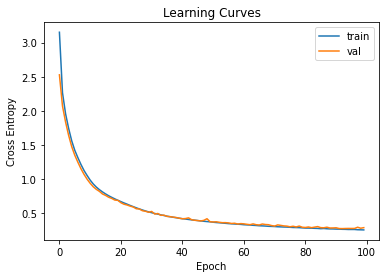

In [11]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2, shuffle=True,
                   use_multiprocessing=True)

# Plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [ ]:
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import StratifiedKFold


### Evaluate and Serialize Model <a id="evaluate"></a>

In [12]:
# Evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)

# Make a prediction
row = np.random.randn(1, n_features)
yhat = model.predict([row])
print('Predicted: %s (class=%d | %s)' % (yhat, np.argmax(yhat), list(le.inverse_transform([np.argmax(yhat)]))[0]))

Test Accuracy: 0.929
Predicted: [[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 1.1592346e-37 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  4.3237393e-14 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 9.1949582e-01 0.0000000e+00 0.0000000e+00 8.0504179e-02
  0.0000000e+00]] (class=31 | W)


In [13]:
if not os.path.exists("generated_model"):
    os.mkdir("generated_model")
    
# Save model to file
model.save("generated_model/3.1a_hand_gesture_model.h5")

## 4. Real-time Detections with Model <a id="real-time-detection"></a>

In [14]:
# Load the model from file
model_inference = load_model("generated_model/3.1a_hand_gesture_model.h5")

# Load the class names
le = LabelEncoder()
le.classes_ = np.load("data/hand_geture_classes.npy", allow_pickle=True)

# Define a text list to store result
text = []

In [15]:
def SignDetection(text):
    cap = cv2.VideoCapture(0)

    pTime = 0

    # represents the top left corner of rectangle
    start_point = (300, 60)

    # represents the bottom right corner of rectangle
    end_point = (600, 380)

    # Blue color in BGR
    color = (255, 0, 0)

    # Line thickness of 2 px
    thickness = 2

    result = []

    with mp.hands.Hands(max_num_hands=1, min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:

        while True:
            success, frame = cap.read()

            if not success:
                break

            # Recolor feed
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Make detections
            results = hands.process(image)

            if results.multi_hand_landmarks:
                for hand_landmark in results.multi_hand_landmarks:

                    # Draw hand landmarks
                    mp.drawing_utils.draw_landmarks(image, hand_landmark, mp.hands.HAND_CONNECTIONS)

                    hand = hand_landmark.landmark
                    row = np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] 
                                              for landmark in hand]).flatten()

                    # Predict using inference model
                    pred = model_inference.predict(row.reshape(1, -1))
                    class_name = list(le.inverse_transform([np.argmax(pred)]))[0]
                    prob = np.max(pred).round(2)
                    output = ''.join(result)  # Define Output Text
                    #print(class_name, prob)  

                    # Display result 
                    cv2.rectangle(image, (0,0), (250,60), (245, 117, 16), -1)
                    cv2.putText(image, "CLASS", (95,12), cv2.FONT_HERSHEY_SIMPLEX,
                               0.5, (0,0,0), 1, cv2.LINE_AA)
                    cv2.putText(image, class_name, (90,40), cv2.FONT_HERSHEY_SIMPLEX,
                               1, (255, 255, 255), 2, cv2.LINE_AA)
                    cv2.putText(image, "PROB", (15,12), cv2.FONT_HERSHEY_SIMPLEX,
                               0.5, (0,0,0), 1, cv2.LINE_AA)
                    cv2.putText(image, str(prob), (10,40), cv2.FONT_HERSHEY_SIMPLEX,
                               1, (255, 255, 255), 2, cv2.LINE_AA)

                    # Display Output Text
                    cv2.rectangle(image, (0,400), (650,500), (245, 117, 16), -1)
                    cv2.putText(image, "RESULT", (15,420), cv2.FONT_HERSHEY_SIMPLEX,
                               0.5, (0,0,0), 1, cv2.LINE_AA)
                    cv2.putText(image, output, (10,460), cv2.FONT_HERSHEY_SIMPLEX,
                               1, (255, 255, 255), 2, cv2.LINE_AA) 


                    # Display framerate
                    cTime = time.time()
                    fps = 1/(cTime-pTime)
                    pTime = cTime
                    cv2.putText(image, f"FPS: {int(fps)}", (500, 50), cv2.FONT_HERSHEY_PLAIN,
                                2, (255, 0, 0), 2)

                    # Retrieve Output Text
                    if (prob >= 0.8) & (keyboard.is_pressed("enter")):  # Detect 'm' input
                        result.append(class_name)
                        time.sleep(1)

                    if (keyboard.is_pressed("space")):  # Detect 'n' input to add space
                        result.append(' ')
                        time.sleep(1)


            # Recolor for rendering
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            # Draw a rectangle with blue line borders of thickness of 2 px
            image = cv2.rectangle(image, start_point, end_point, color, thickness)


            cv2.imshow("Hand detection", image)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()

    # Store into text list
    if result:   #If not empty list, then append
        text.append(''.join(result))


https://www.kaggle.com/datamunge/sign-language-mnist

# UI Console

In [16]:
import pandas as pd

# assign data of lists.  
data = {'Name': ['MOCHA', 'LATTE', 'CHOCO', 'APPLE', 'OREN', 'MANGO', 'PANDAN', 'CARAMEL', 'CARROT'], 
        'Category': ['COFFEE', 'COFFEE', 'COFFEE', 'JUICE', 'JUICE', 'JUICE', 'CAKE', 'CAKE', 'CAKE'],
        'Price': [8.99, 9.99, 10.99, 7.99, 6.99, 5.99, 12.59, 10.10, 15.20]}  
df = pd.DataFrame(data)
df

,Name,Category,Price
0,MOCHA,COFFEE,8.99
1,LATTE,COFFEE,9.99
2,CHOCO,COFFEE,10.99
3,APPLE,JUICE,7.99
4,OREN,JUICE,6.99
5,MANGO,JUICE,5.99
6,PANDAN,CAKE,12.59
7,CARAMEL,CAKE,10.10
8,CARROT,CAKE,15.20


In [17]:
def Menu(text):
    rslt_df = df.loc[df['Category'] == text[0]]
    rslt_df = rslt_df.reset_index(drop=True)
    print("\nPlease Pick One From Below: ")
    print("Name        Price")
    print("-----------------")
    for x in range(len(rslt_df)):
        print('%s       %.2f' % (rslt_df['Name'][x], rslt_df['Price'][x]))
    print("\n")


In [18]:
def Price(text):
    rslt_df = df.loc[df['Name'] == text[1]]
    rslt_df = rslt_df.reset_index(drop=True)
    for x in range(len(rslt_df)):
        text.append(rslt_df['Price'][x])


In [19]:
def Main(text): 
    # Define a text list to store result
#     text = ['CAKE', 'CARROT']
    a = input("ZhenLi Coffee Shop \n" 
              "Please Pick One Category to Proceed \n"
              " - Coffee \n - Juice \n - Cake \n"
              "1. Start Sign Detection \n"
              "Your input is: ")
    userinput = int(a)
    
    if (userinput == 1):
        print("\nOpening Camera....")
        print("Tips: 'Enter' to confirm sign || 'q' to end program")
        SignDetection(text) # Return user input
        print("\nYou have picked : " + text[0])
        rslt_df = df.loc[df['Category'] == text[0]]
        Menu(text)  #Print all menu item
        
        b = input("1. Start Sign Detection \n"
                  "Your input is: ")
        userinput = int(b)
        if (userinput == 1):
            print("\nOpening Camera....")
            print("Tips: 'Enter' to confirm sign || 'q' to end program")
            SignDetection(text)
            print("\nYou have picked : " + text[1])
        else: 
            raise Exception("Enter correct input") 
        
        Price(text)    #Find the price
        
        print("\n\n--------------")
        print("Your Orders:")
        print("--------------")
        print("You have ordered a %s %s" %(text[1],text[0]))
        print("Total Price: RM %.2f" %text[2])
    else: 
        raise Exception("Enter correct input") 
    
    return text

In [20]:
text=[]
text = Main(text)

ZhenLi Coffee Shop 
Please Pick One Category to Proceed 
 - Coffee 
 - Juice 
 - Cake 
1. Start Sign Detection 
Your input is: 1

Opening Camera....
Tips: 'Enter' to confirm sign || 'q' to end program


IndexError: list index out of range

In [ ]:
text

# Pos Taging

In [ ]:
# Create DataFrame
df = pd.DataFrame(columns = ['text', 'tagged_text'])

for x in text:
    print(x)
    tag_text = word_tokenize(x)
    pos_text = nltk.pos_tag(tag_text)
    #Insert into dataframe
    df_length = len(df)
    df.loc[df_length] = [x,pos_text]
    
df

# Parsing (Parse Tree)

In [ ]:
# Extract all parts of speech from any text
chunker = RegexpParser("""
                       NP: {<DT>?<JJ>*<NN>}    #To extract Noun Phrases
                       P: {<IN>}               #To extract Prepositions
                       V: {<V.*>}              #To extract Verbs
                       PP: {<p> <NP>}          #To extract Prepositional Phrases
                       VP: {<V> <NP|PP>*}      #To extract Verb Phrases
                       """)

# Print all parts of speech in above sentence
for x in range(len(df)):
    print("Before Extracting\n", df['text'][x])
    output = chunker.parse(df['tagged_text'][x])
    print("After Extracting\n", output)
    
    # To draw the parse tree
    output.draw()

# Grammar Designing